### KDD Process (ricordare cosa dobbiamo fare (indicate dal prof))
1. Dataset load and features semantics
1. Data Cleaning (handle missing values, remove useless variables)
1. Feature Engineering
1. Classification Preprocessing (feature reshaping, train/test partitioning)
1. Parameter Tuning
1. Perform Classification
1. Analyze the classification results
1. Analyze the classification performance
1. Can we improve the performance using another classifier?

In [75]:
import matplotlib.pylab as plt
import numpy as np
import pandas as pd

from scipy.stats import chi2_contingency
from sklearn.preprocessing import LabelEncoder

### Dataset load and features semantics

In [2]:
# load the dataset 
df = pd.read_csv("data/telecom_users.csv")
df.head()

,Unnamed: 0,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,1869,7010-BRBUU,Male,0,Yes,Yes,72,Yes,Yes,No,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Credit card (automatic),24.10,1734.65,No
1,4528,9688-YGXVR,Female,0,No,No,44,Yes,No,Fiber optic,...,Yes,No,Yes,No,Month-to-month,Yes,Credit card (automatic),88.15,3973.2,No
2,6344,9286-DOJGF,Female,1,Yes,No,38,Yes,Yes,Fiber optic,...,No,No,No,No,Month-to-month,Yes,Bank transfer (automatic),74.95,2869.85,Yes
3,6739,6994-KERXL,Male,0,No,No,4,Yes,No,DSL,...,No,No,No,Yes,Month-to-month,Yes,Electronic check,55.90,238.5,No
4,432,2181-UAESM,Male,0,No,No,2,Yes,No,DSL,...,Yes,No,No,No,Month-to-month,No,Electronic check,53.45,119.5,No


- ``customerID``- customer id;
- ``gender`` - client gender (male / female)
- ``SeniorCitizen`` - is the client retired (1, 0)
- ``Partner`` - is the client married (Yes, No)
- ``Dependents`` - has dependents (Yes, No)
- ``tenure`` - how many months a person has been a client of the company
- ``PhoneService`` - is the telephone service connected (Yes, No)
- ``MultipleLines`` - are multiple phone lines connected (Yes, No, No phone service)
- ``InternetService`` - client's Internet service provider (DSL, Fiber optic, No)
- ``OnlineSecurity`` - is the online security service connected (Yes, No, No internet service)
- ``OnlineBackup`` - is the online backup service activated (Yes, No, No internet service)
- ``DeviceProtection`` - does the client have equipment insurance (Yes, No, No internet service)
- ``TechSupport`` - is the technical support service connected (Yes, No, No internet service)
- ``StreamingTV`` - is the streaming TV service connected (Yes, No, No internet service)
- ``StreamingMovies`` - is the streaming cinema service activated (Yes, No, No internet service)
- ``Contract`` - type of customer contract (Month-to-month, One year, Two year)
- ``PaperlessBilling`` - whether the client uses paperless billing (Yes, No)
- ``PaymentMethod`` - payment method (Electronic check, Mailed check, Bank transfer (automatic), Credit card (automatic))
- ``MonthlyCharges`` - current monthly payment
- ``TotalCharges`` - the total amount that the client paid for the services for the entire time
- ``Churn`` - whether there was a churn (Yes or No)

In [47]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5986 entries, 0 to 5985
Data columns (total 23 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customerID         5986 non-null   object 
 1   gender             5986 non-null   object 
 2   SeniorCitizen      5986 non-null   int64  
 3   Partner            5986 non-null   object 
 4   Dependents         5986 non-null   object 
 5   tenure             5986 non-null   int64  
 6   PhoneService       5986 non-null   object 
 7   MultipleLines      5986 non-null   object 
 8   InternetService    5986 non-null   object 
 9   OnlineSecurity     5986 non-null   object 
 10  OnlineBackup       5986 non-null   object 
 11  DeviceProtection   5986 non-null   object 
 12  TechSupport        5986 non-null   object 
 13  StreamingTV        5986 non-null   object 
 14  StreamingMovies    5986 non-null   object 
 15  Contract           5986 non-null   object 
 16  PaperlessBilling   5986 

## Data cleaning

TotalCharges: In this column there were 10 missing values. Analyzing this records we have noticed that in all of them 'tenure' was zero, so new customers that haven't done still the first payment. So we decided to fill TotalCharges with 0.

In [4]:
df['TotalCharges'] = np.where(df['tenure'] == 0, 0, df['TotalCharges'])

In [5]:
df.isnull().sum()

Unnamed: 0          0
customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [6]:
df['TotalCharges'] = df['TotalCharges'].astype(float)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5986 entries, 0 to 5985
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        5986 non-null   int64  
 1   customerID        5986 non-null   object 
 2   gender            5986 non-null   object 
 3   SeniorCitizen     5986 non-null   int64  
 4   Partner           5986 non-null   object 
 5   Dependents        5986 non-null   object 
 6   tenure            5986 non-null   int64  
 7   PhoneService      5986 non-null   object 
 8   MultipleLines     5986 non-null   object 
 9   InternetService   5986 non-null   object 
 10  OnlineSecurity    5986 non-null   object 
 11  OnlineBackup      5986 non-null   object 
 12  DeviceProtection  5986 non-null   object 
 13  TechSupport       5986 non-null   object 
 14  StreamingTV       5986 non-null   object 
 15  StreamingMovies   5986 non-null   object 
 16  Contract          5986 non-null   object 


Removed useless column

In [8]:
df.drop('Unnamed: 0', axis=1, inplace = True)

In [9]:
churn_encoder = LabelEncoder()
df['Churn'] = churn_encoder.fit_transform(df['Churn'])

### Feature Engineering

In [10]:
df['AvgMonthlyCharges'] = np.where(df['tenure'] == 0, df['TotalCharges'], df['TotalCharges']/df['tenure'])

In [11]:
cols = list(df.columns)
a, b = cols.index('Churn'), cols.index('AvgMonthlyCharges')
cols[b], cols[a] = cols[a], cols[b]
df = df[cols]

In [12]:
df['AvgMonthlyCharges'] = df['AvgMonthlyCharges'].round(decimals=2)
df

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,AvgMonthlyCharges,Churn
0,7010-BRBUU,Male,0,Yes,Yes,72,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,Two year,No,Credit card (automatic),24.10,1734.65,24.09,0
1,9688-YGXVR,Female,0,No,No,44,Yes,No,Fiber optic,No,...,No,Yes,No,Month-to-month,Yes,Credit card (automatic),88.15,3973.20,90.30,0
2,9286-DOJGF,Female,1,Yes,No,38,Yes,Yes,Fiber optic,No,...,No,No,No,Month-to-month,Yes,Bank transfer (automatic),74.95,2869.85,75.52,1
3,6994-KERXL,Male,0,No,No,4,Yes,No,DSL,No,...,No,No,Yes,Month-to-month,Yes,Electronic check,55.90,238.50,59.62,0
4,2181-UAESM,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,Month-to-month,No,Electronic check,53.45,119.50,59.75,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5981,0684-AOSIH,Male,0,Yes,No,1,Yes,No,Fiber optic,Yes,...,No,Yes,Yes,Month-to-month,Yes,Electronic check,95.00,95.00,95.00,1
5982,5982-PSMKW,Female,0,Yes,Yes,23,Yes,Yes,DSL,Yes,...,Yes,Yes,Yes,Two year,Yes,Credit card (automatic),91.10,2198.30,95.58,0
5983,8044-BGWPI,Male,0,Yes,Yes,12,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,Month-to-month,Yes,Electronic check,21.15,306.05,25.50,0
5984,7450-NWRTR,Male,1,No,No,12,Yes,Yes,Fiber optic,No,...,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.45,1200.15,100.01,1


number of active services per row
- Phone service implies MultipleLines
- InternetService implies OtherServices

In [26]:
df['Nservices'] = (df[df.columns[6:15]] == 'Yes').sum(axis=1)
df['Nservices'] = np.where(df['InternetService'] == 'No', df['Nservices'], df['Nservices'] + 1)

In [30]:
# pd.set_option('max_columns', None)

## Exploratory Analysis 

In [14]:
df.describe()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,AvgMonthlyCharges,Churn,Nservices
count,5986.000000,5986.000000,5986.000000,5986.000000,5986.000000,5986.000000,5986.000000
mean,0.161377,32.468760,64.802213,2294.221559,64.735672,0.265119,3.765119
std,0.367909,24.516391,30.114702,2274.164124,30.309495,0.441433,2.019610
min,0.000000,0.000000,18.250000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,9.000000,35.650000,401.587500,35.917500,0.000000,2.000000
50%,0.000000,29.000000,70.400000,1408.575000,70.450000,0.000000,4.000000
75%,0.000000,56.000000,89.900000,3841.500000,90.290000,1.000000,5.000000
max,1.000000,72.000000,118.750000,8684.800000,121.400000,1.000000,8.000000


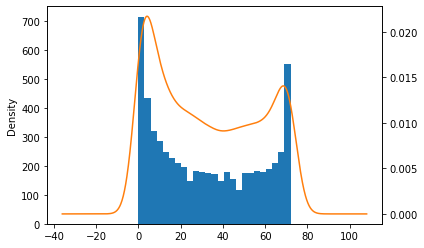

In [15]:
ax = df['tenure'].plot(kind='hist',  bins=25)
df['tenure'].plot(kind='kde', ax=ax, secondary_y=True)

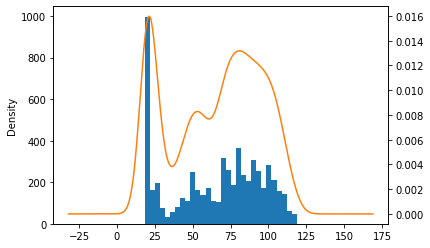

In [16]:
ax = df['MonthlyCharges'].plot(kind='hist',  bins=30)
df['MonthlyCharges'].plot(kind='kde', ax=ax, secondary_y=True)

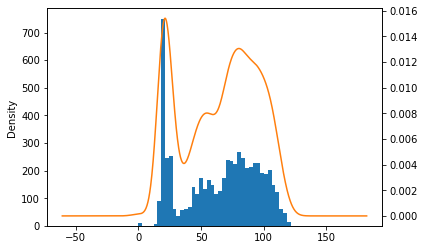

In [17]:
ax = df['AvgMonthlyCharges'].plot(kind='hist',  bins=40)
df['AvgMonthlyCharges'].plot(kind='kde', ax=ax, secondary_y=True)

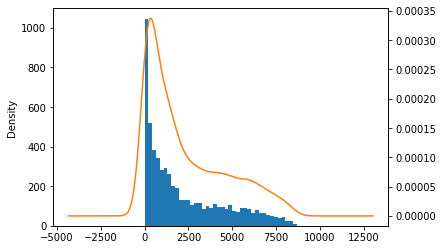

In [18]:
ax = df['TotalCharges'].plot(kind='hist',  bins=40)
df['TotalCharges'].plot(kind='kde', ax=ax, secondary_y=True)

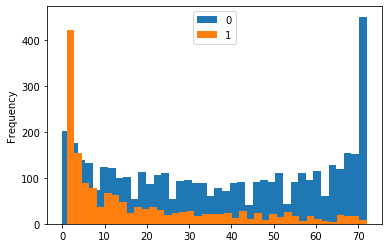

In [19]:
ax = df.groupby(['Churn']).tenure.plot(kind='hist',  bins=40)
plt.legend()
plt.show()

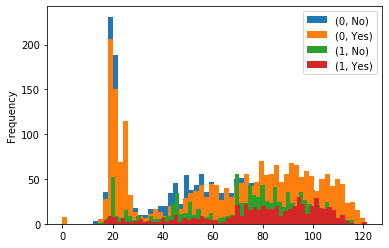

In [20]:
ax = df.groupby(['Churn','Partner']).AvgMonthlyCharges.plot(kind='hist',  bins=60)
plt.legend()
plt.show()

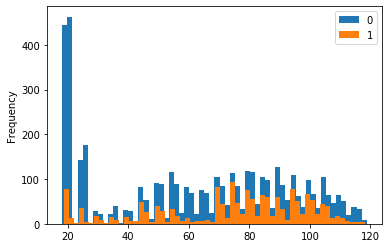

In [21]:
ax = df.groupby(['Churn']).MonthlyCharges.plot(kind='hist',  bins=60)
plt.legend()
plt.show()

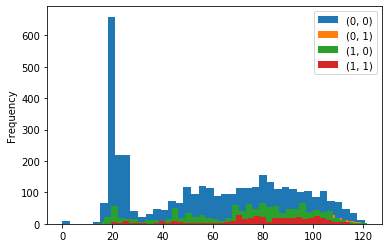

In [22]:
ax = df.groupby(['Churn','SeniorCitizen']).AvgMonthlyCharges.plot(kind='hist',  bins=40)
plt.legend()
plt.show()

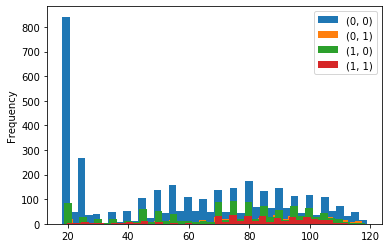

In [23]:
ax = df.groupby(['Churn','SeniorCitizen']).MonthlyCharges.plot(kind='hist',  bins=40)
plt.legend()
plt.show()

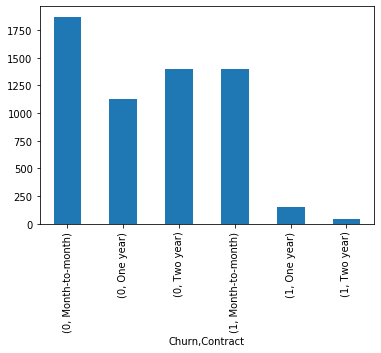

In [46]:
ax = df.groupby(['Churn','Contract']).Contract.count().plot(kind='bar')
plt.show()

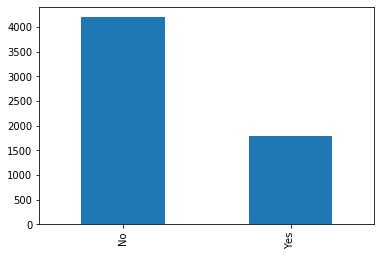

In [53]:
df['Dependents'].value_counts().plot(kind='bar')

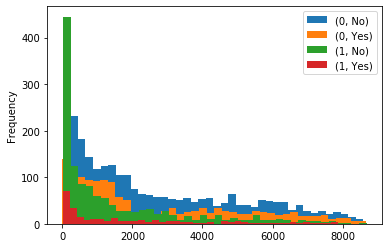

In [63]:
ax = df.groupby(['Churn','Dependents']).TotalCharges.plot(kind='hist', bins=40)
plt.legend()
plt.show()

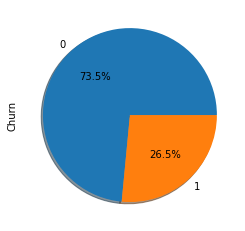

In [74]:
df.Churn.value_counts().plot(kind='pie', autopct='%1.1f%%', shadow=True, startangle=0)

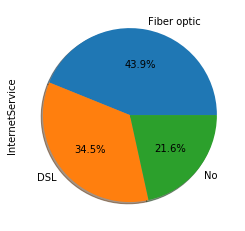

In [85]:
df.InternetService.value_counts().plot(kind='pie', autopct='%1.1f%%', shadow=True, startangle=0)

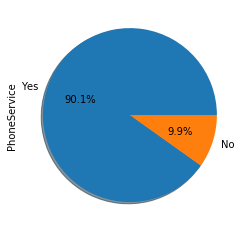

In [86]:
df.PhoneService.value_counts().plot(kind='pie', autopct='%1.1f%%', shadow=True, startangle=0)

In [77]:
pd.crosstab(df.StreamingTV, df.StreamingMovies)

StreamingMovies,No,No internet service,Yes
StreamingTV,,,
No,1710,0,679
No internet service,0,1291,0
Yes,646,0,1660
